In [1]:
# System things
import os

# Data manipulation
import pandas as pd
import numpy as np

# Data viz
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

# Data analytics
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import linear_model, svm, neighbors, ensemble, neural_network

# Data pipeline for model fitting
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_validate
from sklearn.inspection import permutation_importance
from sklearn import metrics
import shap

# Read in data

In [2]:
raw_data = pd.read_csv('../data/03_analytic/clean_data.csv').drop(['Unnamed: 0'], axis=1)
data = raw_data.copy()
data.describe()

,Status,Progress,Duration (in seconds),Finished,credential,years_experience_aba,age,gender,low_low_low_low,low_low_med_low,low_low_high_low,low_low_low_med,low_low_med_med,low_low_high_med,low_low_low_high,low_low_med_high,low_low_high_high,low_med_low_low,low_med_med_low,low_med_high_low,low_med_low_med,low_med_med_med,low_med_high_med,low_med_low_high,low_med_med_high,low_med_high_high,low_high_low_low,low_high_med_low,low_high_high_low,low_high_low_med,low_high_med_med,low_high_high_med,low_high_low_high,low_high_med_high,low_high_high_high,low_low_low_low.1,med_low_med_low,med_low_high_low,med_low_low_med,med_low_med_med,med_low_high_med,med_low_low_high,med_low_med_high,med_low_high_high,med_med_low_low,med_med_med_low,med_med_high_low,med_med_low_med,med_med_med_med,med_med_high_med,med_med_low_high,med_med_med_high,med_med_high_high,med_high_low_low,med_high_med_low,med_high_high_low,med_high_low_med,med_high_med_med,med_high_high_med,med_high_low_high,med_high_med_high,med_high_high_high,high_low_low_low,high_low_med_low,high_low_high_low,high_low_low_med,high_low_med_med,high_low_high_med,high_low_low_high,high_low_med_high,high_low_high_high,high_med_low_low,high_med_med_low,high_med_high_low,high_med_low_med,high_med_med_med,high_med_high_med,high_med_low_high,high_med_med_high,high_med_high_high,high_high_low_low,high_high_med_low,high_high_high_low,high_high_low_med,high_high_med_med,high_high_high_med,high_high_low_high,high_high_med_high,high_high_high_high
count,44.0,44.0,44.000000,44.0,43.000000,44.000000,43.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,43.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,43.000000,44.000000,44.000000,44.000000,43.000000,44.000000,43.00000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,43.000000,44.000000,44.000000,44.000000,44.000000,44.000000,43.000000,43.00000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,43.000000,43.000000,44.000000,44.000000,43.000000,44.000000,44.000000,43.000000
mean,0.0,100.0,944.409091,1.0,4.348837,4.659091,34.139535,1.681818,1.409091,1.431818,1.340909,1.272727,1.272727,1.227273,1.250000,1.255814,1.272727,1.772727,1.750000,1.704545,1.568182,1.500000,1.431818,1.386364,1.295455,1.318182,1.840909,1.863636,1.818182,1.818182,1.863636,1.886364,1.681818,1.568182,1.500000,1.431818,1.488372,1.363636,1.386364,1.227273,1.348837,1.295455,1.27907,1.250000,1.659091,1.704545,1.704545,1.704545,1.613636,1.386364,1.318182,1.318182,1.295455,1.795455,1.840909,1.818182,1.818182,1.863636,1.818182,1.795455,1.697674,1.500000,1.636364,1.681818,1.613636,1.318182,1.325581,1.27907,1.340909,1.318182,1.272727,1.795455,1.795455,1.795455,1.750000,1.750000,1.704545,1.340909,1.318182,1.272727,1.750000,1.860465,1.813953,1.840909,1.886364,1.860465,1.750000,1.772727,1.767442
std,0.0,0.0,640.976773,0.0,1.702711,7.451216,10.176026,0.471155,0.497350,0.501056,0.479495,0.450511,0.450511,0.423915,0.438019,0.441481,0.450511,0.423915,0.438019,0.461522,0.501056,0.505781,0.501056,0.492545,0.461522,0.471155,0.369989,0.347142,0.390154,0.390154,0.347142,0.321038,0.471155,0.501056,0.505781,0.501056,0.505781,0.486607,0.492545,0.423915,0.482243,0.461522,0.45385,0.438019,0.479495,0.461522,0.461522,0.461522,0.492545,0.492545,0.471155,0.471155,0.461522,0.408032,0.369989,0.390154,0.390154,0.347142,0.390154,0.408032,0.464701,0.505781,0.486607,0.471155,0.492545,0.471155,0.474137,0.45385,0.479495,0.471155,0.450511,0.408032,0.408032,0.408032,0.438019,0.438019,0.461522,0.479495,0.471155,0.450511,0.438019,0.350605,0.393750,0.369989,0.321038,0.350605,0.438019,0.423915,0.427463
min,0.0,100.0,270.000000,1.0,1.000000,0

# Look at initial differences across questions

In [3]:
# Prep dataframe
plot_df = data[[col for col in list(data) if (col.startswith("low_")) or (col.startswith("med_")) or (col.startswith("high_")) or (col=='source') or (col=='ResponseId')]]
plot_df = plot_df.melt(id_vars=['source', 'ResponseId'])
plot_df.columns=['source', 'participant', 'scenario', 'choice']
plot_df[::300]

,source,participant,scenario,choice
0,bx_analyst,R_2w6NcI6Jrx51rF1,low_low_low_low,1.0
300,gen_pop,R_2t6bJGRlYY80ZJU,low_low_low_high,1.0
600,gen_pop,R_2WAxCMC47DE4zYK,low_med_med_med,2.0
900,gen_pop,R_1XknF4I91TcKDUB,low_high_high_low,2.0
1200,bx_analyst,R_31jbdooORELfOCE,low_low_low_low.1,2.0
1500,bx_analyst,R_29fSUFKp0RL7akz,med_low_med_high,1.0
1800,gen_pop,R_DNuRbZzZkCBQlIl,med_med_med_med,2.0
2100,gen_pop,R_1OuxL5R9bmTa6Sg,med_high_high_low,2.0
2400,gen_pop,R_3HkuxDHBavmuvaa,high_low_low_low,1.0
2700,gen_pop,R_1gHCuKRpyugis8D,high_low_med_high,2.0


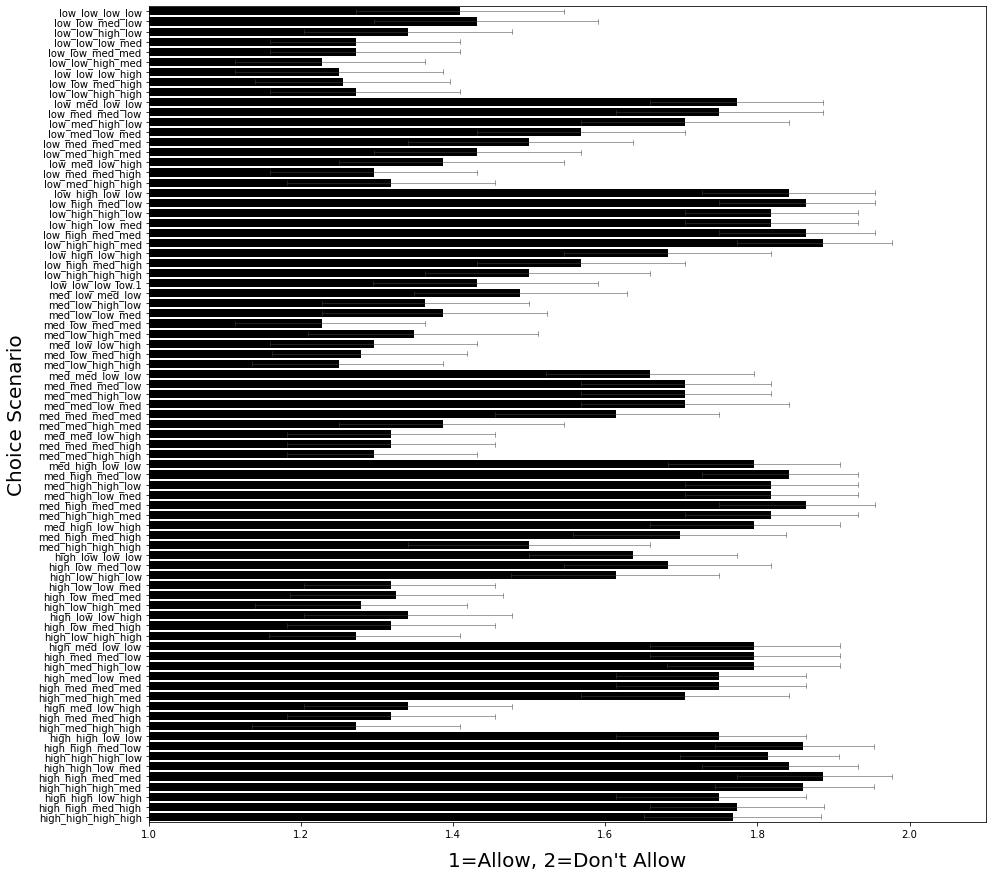

In [4]:
# All conditions all respondents
fig, ax = plt.subplots(figsize=(15, 15))
sns.barplot(y='scenario', x='choice', data=plot_df, color='k', errwidth=.5, capsize=.5)
plt.ylabel("Choice Scenario", fontsize=20, labelpad=12)
plt.xlim(1, 2.1)
plt.xlabel("1=Allow, 2=Don't Allow", fontsize=20, labelpad=12)
plt.show()

In [5]:
# Make the long df easier to groupby different choice scenario characteristics
choice_char = []

for i in range(len(plot_df)):
    val = plot_df['scenario'][i].split("_")
    choice_char.append(val)

choice_char = pd.DataFrame(choice_char)
choice_char.columns = ['first_tele', 'first_harm', 'sec_tele', 'sec_harm']
plot_df = pd.concat([plot_df, choice_char], axis=1)
plot_df = plot_df.replace('low.1', 'low')
plot_df

,source,participant,scenario,choice,first_tele,first_harm,sec_tele,sec_harm
0,bx_analyst,R_2w6NcI6Jrx51rF1,low_low_low_low,1.0,low,low,low,low
1,bx_analyst,R_u4UBRJcTeUC1yPT,low_low_low_low,1.0,low,low,low,low
2,bx_analyst,R_25Kjw8pvt3nUO7o,low_low_low_low,1.0,low,low,low,low
3,bx_analyst,R_cZaE8YMWB2XuGxb,low_low_low_low,1.0,low,low,low,low
4,bx_analyst,R_29fSUFKp0RL7akz,low_low_low_low,1.0,low,low,low,low
...,...,...,...,...,...,...,...,...
3559,gen_pop,R_6Gy2uOTOvzkY0QF,high_high_high_high,2.0,high,high,high,high
3560,gen_pop,R_DNuRbZzZkCBQlIl,high_high_high_high,2.0,high,high,high,high
3561,gen_pop,R_vlu8srmFxMtgo8x,high_high_high_high,2.0,high,high,high,high
3562,gen_pop,R_24FTAEpNvAaeEux,high_high_high_high,2.0,high,high,high,high


# Plots of main effects

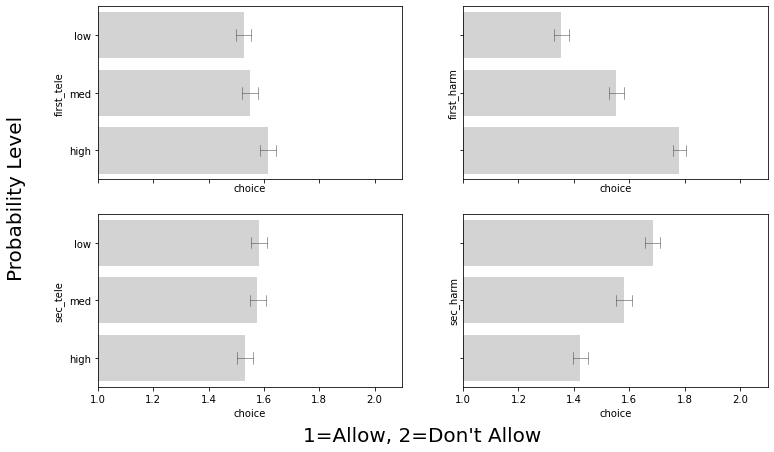

In [6]:
# Choice scenario characteristics
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 7), sharex=True, sharey=True)
sns.barplot(ax=ax[0, 0], y='first_tele', x='choice', data=plot_df, color='lightgray', errwidth=.5, capsize=.2)
sns.barplot(ax=ax[0, 1], y='first_harm', x='choice', data=plot_df, color='lightgray', errwidth=.5, capsize=.2)
sns.barplot(ax=ax[1, 0], y='sec_tele', x='choice', data=plot_df, color='lightgray', errwidth=.5, capsize=.2)
sns.barplot(ax=ax[1, 1], y='sec_harm', x='choice', data=plot_df, color='lightgray', errwidth=.5, capsize=.2)
fig.supylabel("Probability Level", fontsize=20)
fig.supxlabel("1=Allow, 2=Don't Allow", fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(1, 2.1)
plt.show()

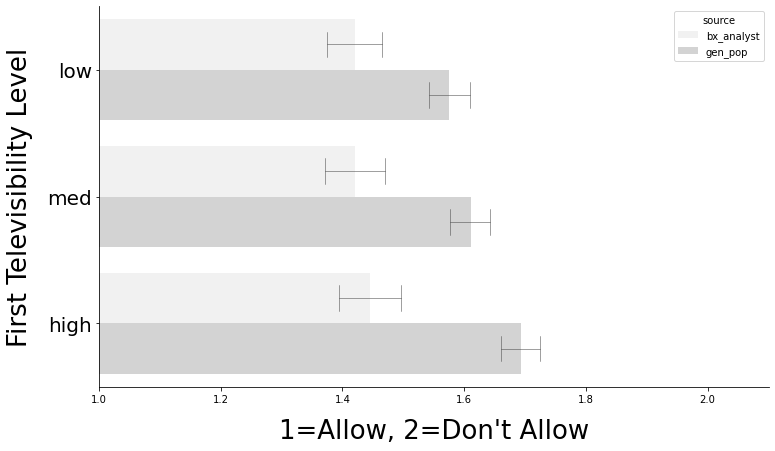

In [7]:
# Choice scenario characteristics
fig, ax = plt.subplots(figsize=(12, 7))
sns.barplot(y='first_tele', x='choice', data=plot_df, hue='source', color='lightgray', errwidth=.5, capsize=.2)
plt.ylabel("First Televisibility Level", fontsize=26, labelpad=14)
plt.xlabel("1=Allow, 2=Don't Allow", fontsize=26, labelpad=14)
plt.yticks(fontsize=20)
plt.xlim(1, 2.1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

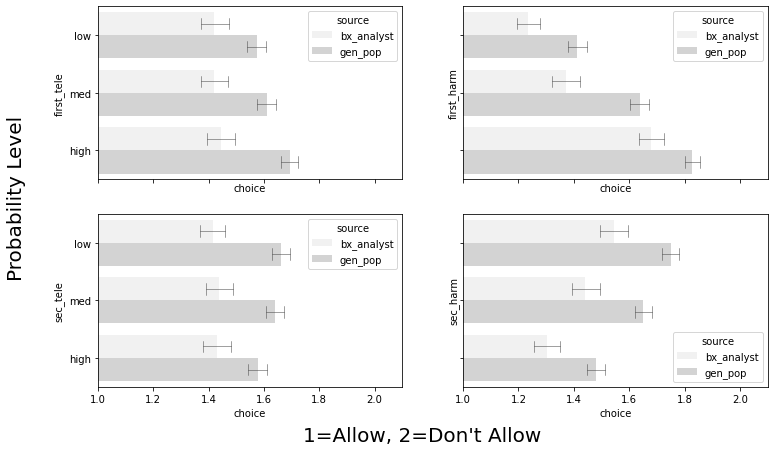

In [8]:
# Choices by scenario and group
# Choice scenario characteristics
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 7), sharex=True, sharey=True)
sns.barplot(ax=ax[0, 0], y='first_tele', x='choice', data=plot_df, hue='source', color='lightgray', errwidth=.5, capsize=.2)
sns.barplot(ax=ax[0, 1], y='first_harm', x='choice', data=plot_df, hue='source', color='lightgray', errwidth=.5, capsize=.2)
sns.barplot(ax=ax[1, 0], y='sec_tele', x='choice', data=plot_df, hue='source', color='lightgray', errwidth=.5, capsize=.2)
sns.barplot(ax=ax[1, 1], y='sec_harm', x='choice', data=plot_df, hue='source', color='lightgray', errwidth=.5, capsize=.2)
fig.supylabel("Probability Level", fontsize=20)
fig.supxlabel("1=Allow, 2=Don't Allow", fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(1, 2.1)
plt.show()

# Statistics

In [9]:
# Check for statistical significance using logistics regression model
features = plot_df[['source', 'first_tele', 'first_harm', 'sec_tele', 'sec_harm']]
fit_dict = {'bx_analyst':0, 'gen_pop':1, 
            'low':0, 'med':1, 'high':2}
features = features.replace(fit_dict)
dv = plot_df['choice']
dv = dv.replace(1, 0)
dv = dv.replace(2, 1)
log_res = sm.Logit(dv, features, missing='drop').fit()
log_res.summary()

Optimization terminated successfully.
         Current function value: 0.577112
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 choice   No. Observations:                 3553
Model:                          Logit   Df Residuals:                     3548
Method:                           MLE   Df Model:                            4
Date:                Mon, 20 Jun 2022   Pseudo R-squ.:                  0.1576
Time:                        06:49:55   Log-Likelihood:                -2050.5
converged:                       True   LL-Null:                       -2434.1
Covariance Type:            nonrobust   LLR p-value:                1.003e-164
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
source         0.6895      0.071      9.732      0.000       0.551       0.828
first_tele     0.0936      0.042      2.209      0.027       0.011       0.177
first_harm     0.8998      0.046     19.651      0.000       0.810       0.990
sec_tele      -0.2707      0.043     -6.363      0.000      -0.354      -0.187
sec_harm      -0.7834      0.045    -17.392      0.000      -0.872      -0.695
==============================================================================
"""

In [10]:
# Convert entire df to numbers
num_df = plot_df.replace(fit_dict)
num_df['choice'] = num_df['choice'].replace(1, 0)
num_df['choice'] = num_df['choice'].replace(2, 1)
num_df.dropna(inplace=True)
num_df = num_df.reset_index(drop=True)
num_df

,source,participant,scenario,choice,first_tele,first_harm,sec_tele,sec_harm
0,0,R_2w6NcI6Jrx51rF1,low_low_low_low,0.0,0,0,0,0
1,0,R_u4UBRJcTeUC1yPT,low_low_low_low,0.0,0,0,0,0
2,0,R_25Kjw8pvt3nUO7o,low_low_low_low,0.0,0,0,0,0
3,0,R_cZaE8YMWB2XuGxb,low_low_low_low,0.0,0,0,0,0
4,0,R_29fSUFKp0RL7akz,low_low_low_low,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...
3548,1,R_6Gy2uOTOvzkY0QF,high_high_high_high,1.0,2,2,2,2
3549,1,R_DNuRbZzZkCBQlIl,high_high_high_high,1.0,2,2,2,2
3550,1,R_vlu8srmFxMtgo8x,high_high_high_high,1.0,2,2,2,2
3551,1,R_24FTAEpNvAaeEux,high_high_high_high,1.0,2,2,2,2


In [11]:
# Check for statistical significance using a OLS linear regression model
reg_res = smf.ols('choice ~ source + first_tele + first_harm + sec_tele + sec_harm', data=num_df).fit()
reg_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 choice   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     188.5
Date:                Mon, 20 Jun 2022   Prob (F-statistic):          1.62e-178
Time:                        06:49:55   Log-Likelihood:                -2131.2
No. Observations:                3553   AIC:                             4274.
Df Residuals:                    3547   BIC:                             4311.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3323      0.022     15.046      0.000       0.289       0.376
source         0.1965      0.016     12.368      0.000       0.165       0.228
first_tele     0.0434      0.009      4.831      0.000       0.026       0.061
first_harm     0.2119      0.009     23.352      0.000       0.194       0.230
sec_tele      -0.0261      0.009     -2.885      0.004      -0.044      -0.008
sec_harm      -0.1315      0.009    -14.507      0.000      -0.149      -0.114
==============================================================================
Omnibus:                     1189.812   Durbin-Watson:                   1.824
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              184.358
Skew:                          -0.161   Prob(JB):                     9.27e-41
Kurtosis:                       1.931   Cond. No.                         8.19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
# Check for statistical significance using a OLS linear regression model
reg_res = smf.ols('choice ~ source + first_tele + first_harm + sec_tele + sec_harm', data=plot_df).fit()
reg_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 choice   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     105.7
Date:                Mon, 20 Jun 2022   Prob (F-statistic):          8.52e-176
Time:                        06:49:55   Log-Likelihood:                -2127.3
No. Observations:                3553   AIC:                             4275.
Df Residuals:                    3543   BIC:                             4336.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.5262      0.025     61.651      0.000       1.478       1.575
source[T.gen_pop]     0.1965      0.016     12.375      0.000       0.165       0.228
first_tele[T.low]    -0.0868      0.018     -4.829      0.000      -0.122      -0.052
first_tele[T.med]    -0.0681      0.018     -3.719      0.000      -0.104      -0.032
first_harm[T.low]    -0.4247      0.018    -23.400      0.000      -0.460      -0.389
first_harm[T.med]    -0.2270      0.018    -12.536      0.000      -0.263      -0.192
sec_tele[T.low]       0.0513      0.018      2.832      0.005       0.016       0.087
sec_tele[T.med]       0.0441      0.018      2.434      0.015       0.009       0.080
sec_harm[T.low]       0.2621      0.018     14.457      0.000       0.227       0.298
sec_harm[T.med]       0.1593      0.018      8.791      0.000       0.124       0.195
==============================================================================
Omnibus:                     1181.866   Durbin-Watson:                   1.827
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              182.708
Skew:                          -0.153   Prob(JB):                     2.12e-40
Kurtosis:                       1.932   Cond. No.                         6.83
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
num_df.isna().sum()

source          0
participant     0
scenario        0
choice         11
first_tele      0
first_harm      0
sec_tele        0
sec_harm        0
dtype: int64

# Above fits weren't great. Can we do better with ML?

In [13]:
# Prep data
features = num_df[['source', 'first_tele', 'first_harm', 'sec_tele', 'sec_harm']]
outc = num_df['choice']

In [14]:
# %% Functions
def fit_algo(model, features, outcome, save_name):
    scoring = {"MAE": "neg_mean_absolute_error",
               "r2": "r2"}
    cv = RepeatedKFold(n_splits=5,
                       n_repeats=10,
                       random_state=431979)
    scores = cross_validate(estimator=model,
                             X=features,
                             y=outcome,
                             groups=None,
                             scoring=scoring,
                             cv=cv,
                             n_jobs=1,
                             verbose=0)
    scores = pd.DataFrame(scores)
    scores['model'] = save_name
    scores.to_csv(f"../data/04_model_outputs/{save_name}.csv")
    print(f"AVG MAE: {abs(round(scores.test_MAE.mean(), 2))}; MAX MAE: {abs(round(scores.test_MAE.max(), 2))}")
    print(f"AVG r2: {round(scores.test_r2.mean(), 2)}; MAX r2: {round(scores.test_r2.max(), 2)}")
    return scores

In [15]:
# Set of all models to test
models = {"Linear Regression": linear_model.LinearRegression(),
          "LASSO Regression": linear_model.LassoCV(),
          "Elastic Net": linear_model.ElasticNetCV(),
          "Bayesian Ridge": linear_model.BayesianRidge(),
          "SGD": linear_model.SGDRegressor(),
          "SVM": svm.SVR(),
          "kNN": neighbors.KNeighborsRegressor(),
          "Random Forest": ensemble.RandomForestRegressor(),
          "ADABoost": ensemble.AdaBoostRegressor(),
          "GDB":ensemble.GradientBoostingRegressor(),
          "Multilayer Perceptron": neural_network.MLPRegressor()}

In [16]:
# Run through the list of models for all outcomes
import warnings
warnings.filterwarnings("ignore")

all_results = pd.DataFrame()

for key, value in models.items():
    print(f"Fitting {key}")
    results = fit_algo(model=value,
                       features=features,
                       outcome=outc,
                       save_name=key)
    all_results = pd.concat([all_results, results])
    print("\n")

all_results.to_csv('../data/04_model_outputs/all_results_cross_val.csv')

Fitting Linear Regression
AVG MAE: 0.39; MAX MAE: 0.38
AVG r2: 0.21; MAX r2: 0.25


Fitting LASSO Regression
AVG MAE: 0.39; MAX MAE: 0.38
AVG r2: 0.21; MAX r2: 0.25


Fitting Elastic Net
AVG MAE: 0.39; MAX MAE: 0.38
AVG r2: 0.21; MAX r2: 0.25


Fitting Bayesian Ridge
AVG MAE: 0.39; MAX MAE: 0.38
AVG r2: 0.21; MAX r2: 0.25


Fitting SGD
AVG MAE: 0.39; MAX MAE: 0.38
AVG r2: 0.2; MAX r2: 0.25


Fitting SVM
AVG MAE: 0.33; MAX MAE: 0.31
AVG r2: 0.07; MAX r2: 0.15


Fitting kNN
AVG MAE: 0.4; MAX MAE: 0.37
AVG r2: 0.04; MAX r2: 0.12


Fitting Random Forest
AVG MAE: 0.38; MAX MAE: 0.37
AVG r2: 0.18; MAX r2: 0.24


Fitting ADABoost
AVG MAE: 0.4; MAX MAE: 0.39
AVG r2: 0.17; MAX r2: 0.22


Fitting GDB
AVG MAE: 0.38; MAX MAE: 0.37
AVG r2: 0.22; MAX r2: 0.27


Fitting Multilayer Perceptron
AVG MAE: 0.38; MAX MAE: 0.36
AVG r2: 0.22; MAX r2: 0.28




# Within-Subject Analyses